In [1]:
%pylab inline
import numpy as np
import cPickle as pickle
import irm
import sklearn.metrics
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
basicmat_data = pickle.load(open("../data/mushroombody.cleandata.pickle", 'r'))
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']


In [3]:
def compute_prob_matrix(tgt_latent, model_name='LogisticDistance', 
                        relation_name = 'R1', domain_name = "d1"):
    """
    Compute the probability of a connection at EVERY LOCATION in the matrix

    Does not depend on the actual observed values of data


    """
    ss = tgt_latent['relations'][relation_name]['ss']
    ass = tgt_latent['domains'][domain_name]['assignment']
    hps = tgt_latent['relations'][relation_name]['hps']
    
    N = len(ass)
    pred = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            c1 = ass[i]
            c2 = ass[j]
            c = ss[(c1, c2)]
            if model_name == "BetaBernoulliNonConj":
                y = c['p']
            else:
                raise NotImplementedError()
            pred[i, j] = y
    return pred


In [45]:
a = pickle.load(open("../data/bbnonconj_1000.results.pickle", 'r'))


In [5]:
job_res = a['job_res']
infiles = a['infiles']
all_exp = a['all_exp']

In [6]:
cv_data = pickle.load(open("../" + infiles[0], 'r'))
conmat = cv_data['conmat']
cvs = cv_data['cvs']

In [7]:
infiles[0]

'data/KC-rosette-KC.MBON-14-A.cv_10.pickle'

In [8]:
len(job_res)

100

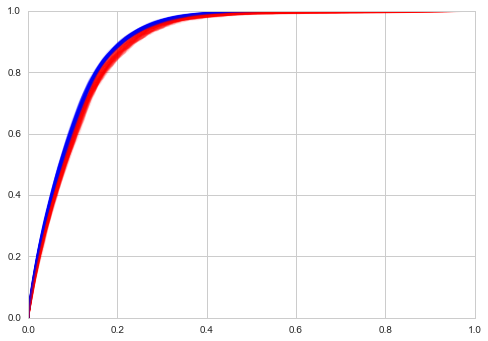

In [9]:
# filename, cv, seed
dfres = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    m = compute_prob_matrix(state, model_name="BetaBernoulliNonConj")
    
    # get the cv matrix 
    cv_mask_flat = cvs[cv_i].flatten()
    for observed in [True, False]:
        if observed:
            idx = np.argwhere(cv_mask_flat==1)
        else:
            idx = np.argwhere(cv_mask_flat==0)
        preds = m.flatten()[idx]
        truths = conmat.flatten()[idx]
        fpr, tpr, _ = sklearn.metrics.roc_curve(truths, preds)
        roc_auc = sklearn.metrics.roc_auc_score(truths, preds)
        pr_auc = sklearn.metrics.average_precision_score(truths, preds)
        dfres.append({'cv_i' : cv_i, 
                      'seed' : seed, 
                       'preds' : preds, 
                        'truths' : truths, 
                      'observed' : observed,
                      'roc_auc' : roc_auc, 
                      'pr_auc' : pr_auc, 
                         })
        if observed:
            pylab.plot(fpr, tpr, c='b', alpha=0.1)
        else:
             pylab.plot(fpr, tpr, c='r', alpha=0.1)
        

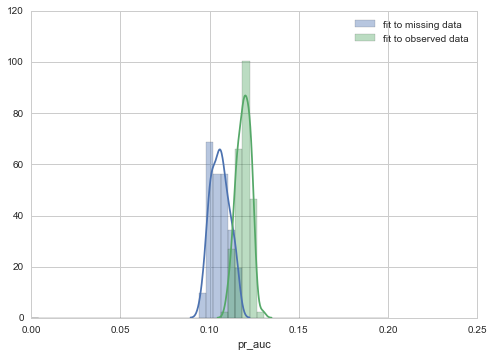

In [43]:
df = pd.DataFrame(dfres)
bins = np.linspace(0, 0.2, 50)

for gi, g in df.groupby('observed'):
    #sns.distplot(g.roc_auc, bins=bins)
    if gi:
        label = "fit to observed data"
    else:
        label = "fit to missing data"
    sns.distplot(g.pr_auc, bins=bins, label=label)
pylab.legend()

In [11]:
all_assign = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    ass = state['domains']['d1']['assignment']
    all_assign.append(ass)
assignments = np.array(all_assign)

In [12]:
all_crp_alpha = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    ass = state['domains']['d1']['hps']['alpha']
    all_crp_alpha.append(ass)
all_crp_alpha = np.array(all_crp_alpha)

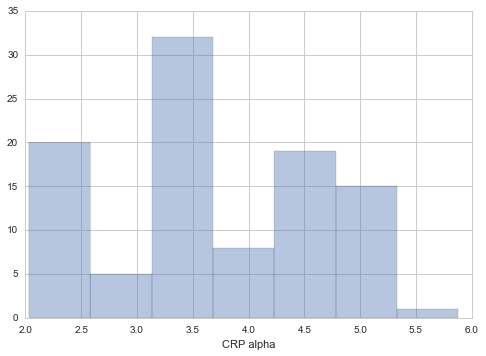

In [13]:
sns.distplot(all_crp_alpha, kde=False)
pylab.xlabel("CRP alpha")

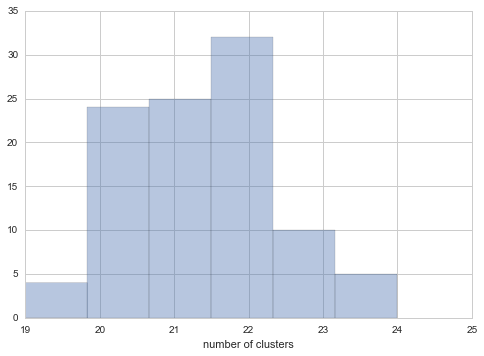

In [14]:
sns.distplot([len(np.unique(a)) for a in assignments], kde=False)
pylab.xlabel("number of clusters")

In [15]:
state['domains']['d1']['hps']

{'alpha': 3.2570206556597832}

In [16]:
# WE WERE SO STUPID and didn't include this in the generated data
THRESHOLD = 20
CONVERGENT = True

d = pickle.load(open("../data/mushroombody.KC-rosette-KC.mats.pickle", 'r'))

a = d['all_results'][(THRESHOLD, CONVERGENT)]

pre_ids_names_sorted = d['pre_ids_names_sorted']
pre_ids_to_pos = d['pre_ids_to_pos']
sort_order = d['sort_order']

In [17]:
pos_to_pre_id = {v : k for k, v in pre_ids_to_pos.iteritems()}

In [18]:
name_color_id = {v : k for k, v in enumerate(np.unique(pre_ids_names_sorted))}
pos_to_name = {}
for pos, pre_id in pos_to_pre_id.iteritems():
    a = neurons_df[neurons_df['body ID'] == pre_id].iloc[0]
    pos_to_name[pos] = a['name']
                 

In [19]:
palette = sns.color_palette("hls", 6)


In [26]:
truth = [name_color_id[pos_to_name[o]] for o in range(len(pos_to_name))]


In [21]:
zm = irm.util.compute_zmatrix(assignments)


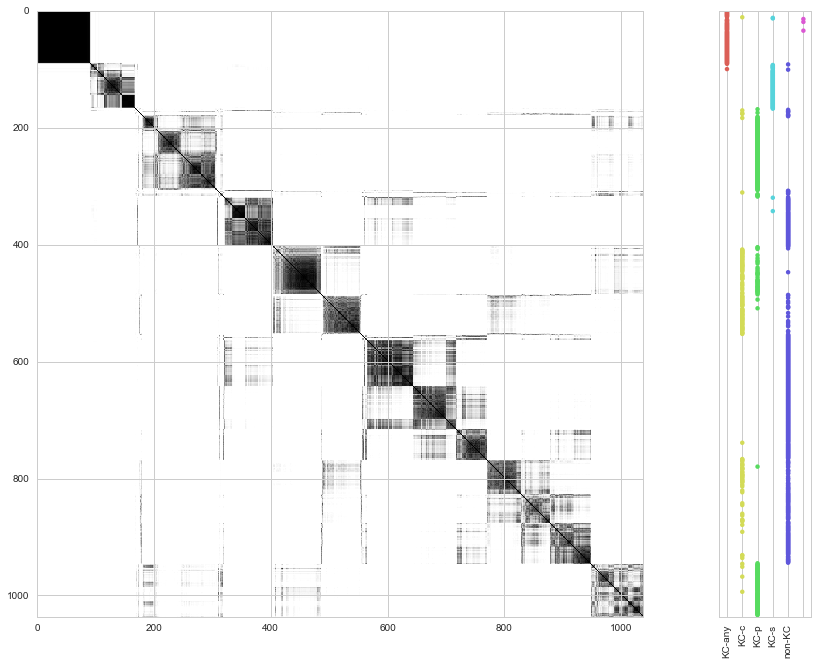

In [25]:
# compare to existing types
import matplotlib.gridspec as gridspec


fig = pylab.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[8,1],
                       height_ratios=[1,1]
                       )

ax_z = pylab.subplot(gs[0])
order = irm.plot.plot_zmatrix(ax_z, zm)

ax_true = pylab.subplot(gs[1])
reordered_truth = [name_color_id[pos_to_name[o]] for o in order]
ax_true.scatter( reordered_truth, range(len(order)), c=[palette[c] for c in reordered_truth], edgecolor='none')
ax_true.set_ylim(len(order)+2, -2)
ax_true.set_xlim(-0.5, 5.5)
ax_true.set_yticks([])
ax_true.set_xticklabels(np.unique(pre_ids_names_sorted), rotation=90)
fig.tight_layout()

1.72033971595


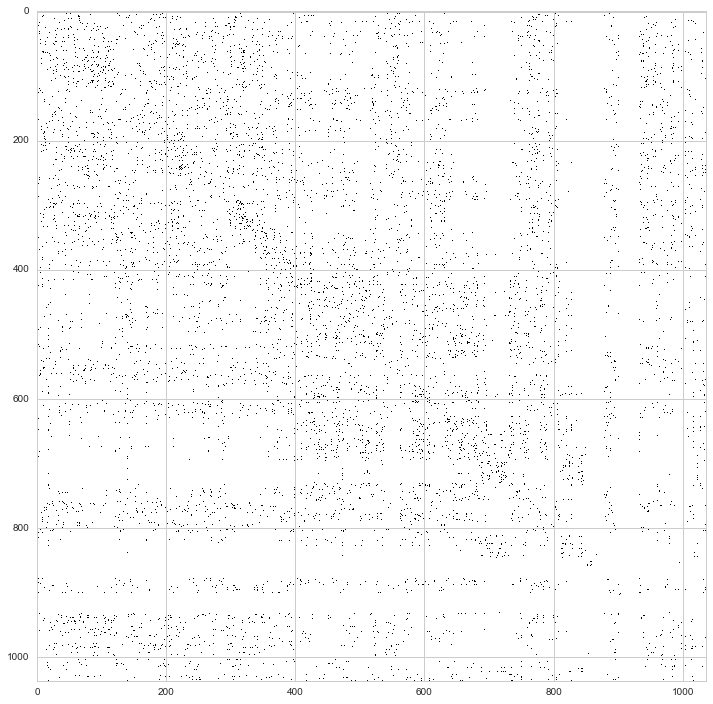

In [27]:
print float(np.sum(conmat)) / (conmat.shape[0]*conmat.shape[1])* 100
pylab.figure(figsize=(12, 12))
pylab.imshow(conmat.astype(np.float32), interpolation='nearest', cmap=pylab.cm.Greys)

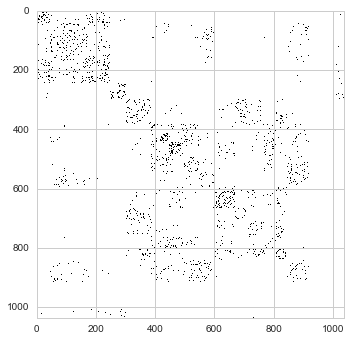

In [28]:
filename, cv_i, seed, res = job_res[4]
score, state, log, _ = res
ass = state['domains']['d1']['assignment']
ci = np.argsort(ass)
m = conmat[ci]
m = m[:, ci]
pylab.imshow(m.astype(np.float32), interpolation='nearest', cmap=pylab.cm.Greys)

In [29]:
ss = state['relations']['R1']['ss']

N = len(ass)
pred = np.zeros((N, N))
stats = {}

for i in range(N):
    for j in range(N):
        c1 = ass[i]
        c2 = ass[j]
        k = (c1, c2)
        if k not in stats:
            stats[k] = [0, 0]
        stats[k][conmat[i, j]] += 1
        
        c = ss[(c1, c2)]

(0, 0.3)

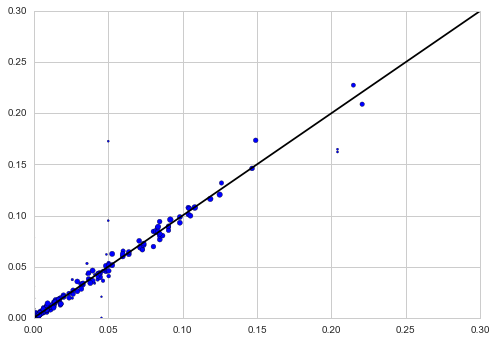

In [30]:
ssdf = []
for k in ss.keys():

    est_prob =  ss[k]['p']
    tails, heads = stats[k]
    n = heads+tails

    emp_prob = heads/float(n)
    ssdf.append({'est_prob': est_prob, 'c1' : k[0], 
                'c2': k[1], 'emp_prob': emp_prob, 
                 'n': n})
ssdf = pd.DataFrame(ssdf)
pylab.scatter(ssdf.emp_prob, ssdf.est_prob, s= ssdf.n**0.4)
pylab.xlim(0, 0.3)
pylab.plot([0, 1], [0, 1], c='k')
pylab.ylim(0, 0.3)


In [31]:
# what are our cluster sizes
resdf = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    ass = state['domains']['d1']['assignment']
    ca = irm.util.canonicalize_assignment(ass)
    cluster_edges = np.cumsum(irm.util.count(ca).values())
    for e in cluster_edges:
        resdf.append({'cv_i' : cv_i, 'seed' : seed, 'cluster_edge' : e, 'ji': ji})
cluster_sizes_df = pd.DataFrame(resdf)

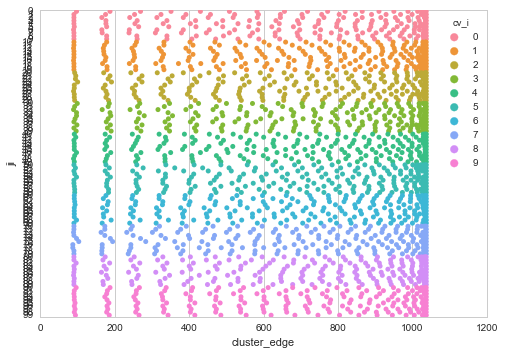

In [32]:
sns.stripplot(x='cluster_edge', y='ji', data=cluster_sizes_df, orient='h', hue='cv_i')

In [33]:
res = []
assignment_subset = assignments
for i in range(len(assignment_subset)):

        a2 = assignment_subset[i]
        res.append({'i' : i, 
                    'ari' : sklearn.metrics.adjusted_rand_score(truth, a2), 
                    'homogeneity' : sklearn.metrics.homogeneity_score(truth, a2), 
                   'completeness' : sklearn.metrics.completeness_score(truth, a2)})
truth_ari_df = pd.DataFrame(res)


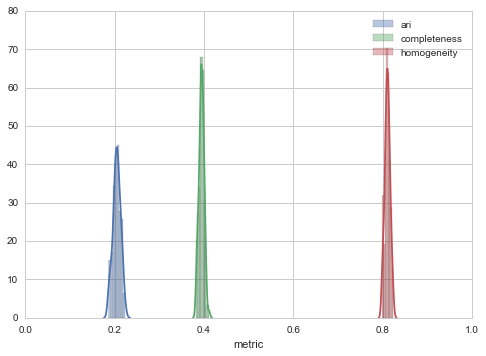

In [34]:
sns.distplot(truth_ari_df.ari, label='ari')
sns.distplot(truth_ari_df.completeness, label='completeness')
sns.distplot(truth_ari_df.homogeneity, label='homogeneity')
pylab.xlim(0, 1)
pylab.xlabel('metric')
pylab.legend()

In [36]:
res = []
for i in range(len(assignment_subset)):
    for j in range(len(assignment_subset)):
        if i > j:
            a1 = assignment_subset[i]
            a2 = assignment_subset[j]
            res.append({'i' : i, 'j' : j, 
                        'ari' : sklearn.metrics.adjusted_rand_score(a1, a2), 
                        'homogeneity' : sklearn.metrics.homogeneity_score(a1, a2), 
                       'completeness' : sklearn.metrics.completeness_score(a1, a2)})
sample_ari_df = pd.DataFrame(res)

(0, 1)

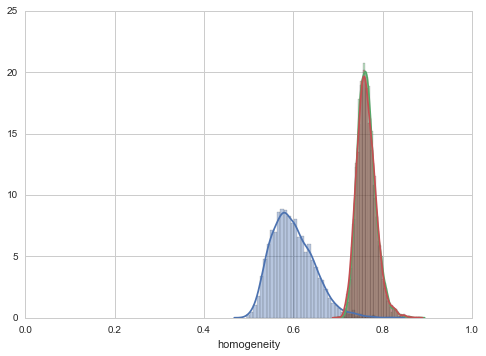

In [37]:
sns.distplot(sample_ari_df.ari)
sns.distplot(sample_ari_df.completeness)
sns.distplot(sample_ari_df.homogeneity)
pylab.xlim(0, 1)

In [38]:
assignment_subset = np.random.poisson(2, (100, 1000))
res = []
for i in range(len(assignment_subset)):
    for j in range(len(assignment_subset)):
        if i > j:
            a1 = assignment_subset[i]
            a2 = assignment_subset[j]
            res.append({'i' : i, 'j' : j, 
                        'ari' : sklearn.metrics.adjusted_rand_score(a1, a2), 
                        'homogeneity' : sklearn.metrics.homogeneity_score(a1, a2), 
                       'completeness' : sklearn.metrics.completeness_score(a1, a2)})
sample_ari_df = pd.DataFrame(res)

(0, 1)

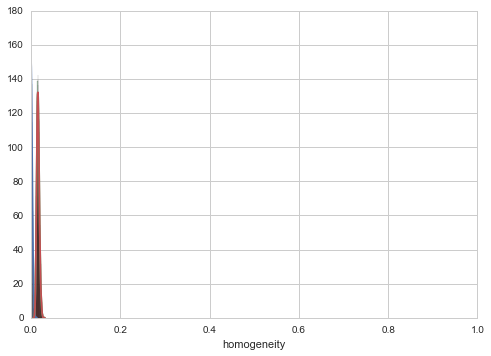

In [39]:
sns.distplot(sample_ari_df.ari)
sns.distplot(sample_ari_df.completeness)
sns.distplot(sample_ari_df.homogeneity)
pylab.xlim(0, 1)